# Homework 4 - Applied Machine Learning  

## Question 1: Propensity score matching

In [721]:
# Import the required libraries for the first task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas.tools.plotting as pplot
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
sns.set(color_codes=True)
%matplotlib inline

### 1. A naive analysis  
Here we will use some plots and statistical measures to get an impression of the treatment effect on the outcome `re78`.

In [723]:
# Read the csv file
data = pd.read_csv('lalonde.csv')

In [724]:
# Get first 10 rows of the data
data.head(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700


In [725]:
# we stored the outcome variable of treated and untreated people in data2 and data1 respectively
data1 = data.loc[data['treat'] == 0,'re78']
data2 = data.loc[data['treat'] == 1,'re78']

In [726]:
# Get a statistical description of the untreated people
data1.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [727]:
# Get a statistical description of the treated people
data2.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

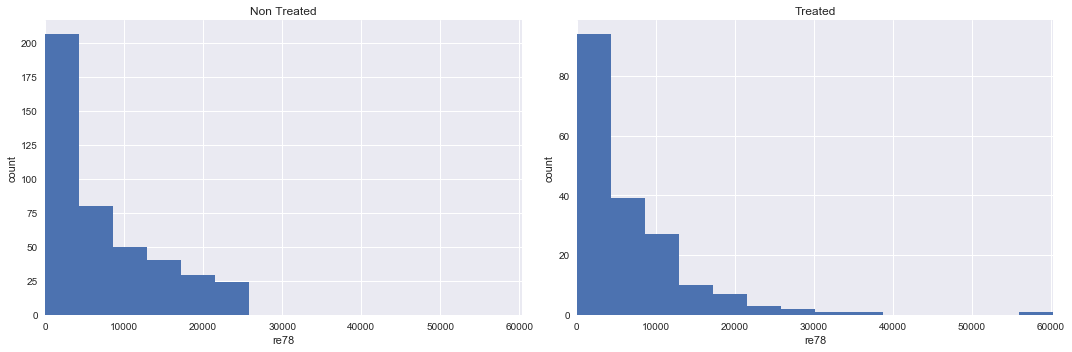

In [728]:
# Plot the outcome variable for untreated and treated people
plt.subplot(1, 2, 1)
max_val = max(data1.max(),data2.max())
min_val = min(data1.min(),data2.min())
data1.hist(figsize=[15,5], bins = np.linspace(min_val,max_val,15)).set_xlim(0,max_val)
plt.title('Non Treated')
plt.xlabel('re78')
plt.ylabel('count')

plt.subplot(1,2,2)
data2.hist(figsize=[15,5],bins = np.linspace(min_val,max_val,15)).set_xlim(0,max_val)
plt.title('Treated')
plt.xlabel('re78')
plt.ylabel('count')

plt.tight_layout()

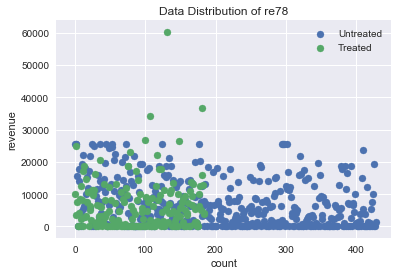

In [729]:
# Plot the outcome distribution of untreated and treated people 
fig, ax1 = plt.subplots()
ax1.scatter(range(len(data['re78'].loc[data['treat'] == 0])), data['re78'].loc[data['treat'] == 0])
ax1.scatter(range(len(data['re78'].loc[data['treat'] == 1])), data['re78'].loc[data['treat'] == 1])
ax1.set_title('Data Distribution of re78')
ax1.legend(['Untreated', 'Treated'],loc='upper right', shadow=True)
ax1.set_xlabel('count')
ax1.set_ylabel('revenue')

/Users/KhalilCherif/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


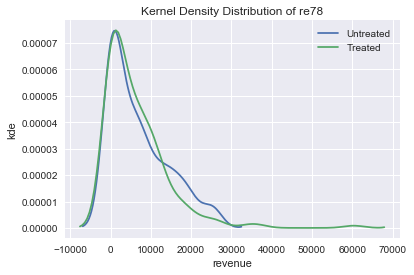

In [730]:
# Plot the kernel density estimation of untreated and treated people
fig, ax1 = plt.subplots()
sns.kdeplot(data1,kernel='gau')
sns.kdeplot(data2, kernel='gau')
ax1.set_title('Kernel Density Distribution of re78')
ax1.legend(['Untreated', 'Treated'],loc='upper right', shadow=True)
ax1.set_xlabel('revenue')
ax1.set_ylabel('kde')

/Users/KhalilCherif/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


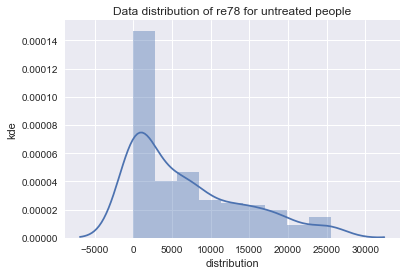

In [731]:
# Plot the outcome distribution over the bar plot for untreated people
fig, ax1 = plt.subplots()
sns.distplot(data1);
ax1.set_title('Data distribution of re78 for untreated people')
ax1.set_xlabel('distribution')
ax1.set_ylabel('kde')

/Users/KhalilCherif/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


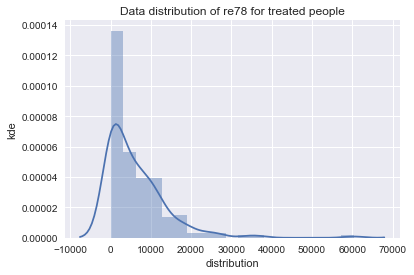

In [732]:
# Plot the outcome distribution over the bar plot for treated people
fig, ax1 = plt.subplots()
sns.distplot(data2);
ax1.set_title('Data distribution of re78 for treated people')
ax1.set_xlabel('distribution')
ax1.set_ylabel('kde')

### What might a naive "researcher" conclude from this superficial analysis?  
By looking at the statistical measures of the two groups, one can see that the mean and median salaries for untreated people is higher than the other ones. But at the same time the maximum salary of treated people is largely higher than the one of untreated people. Thus, a "naive researcher" might conclude that the treatment has no impact on the salary but can help people reach very high salaries around 40K $\$$ or 60K $\$$

## 2. A closer look at the data  
Here we will study the statistical measures and distributions of all variables except for `re78` with consideration to the treated and untreated people.

In [733]:
# Get a statistical description of all variables for the untreated people
non_treated_data = data.loc[data['treat']==0,:]
non_treated_data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


In [734]:
# Get a statistical description of all variables for the treated people
treated_data = data.loc[data['treat']==1,:] 
treated_data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


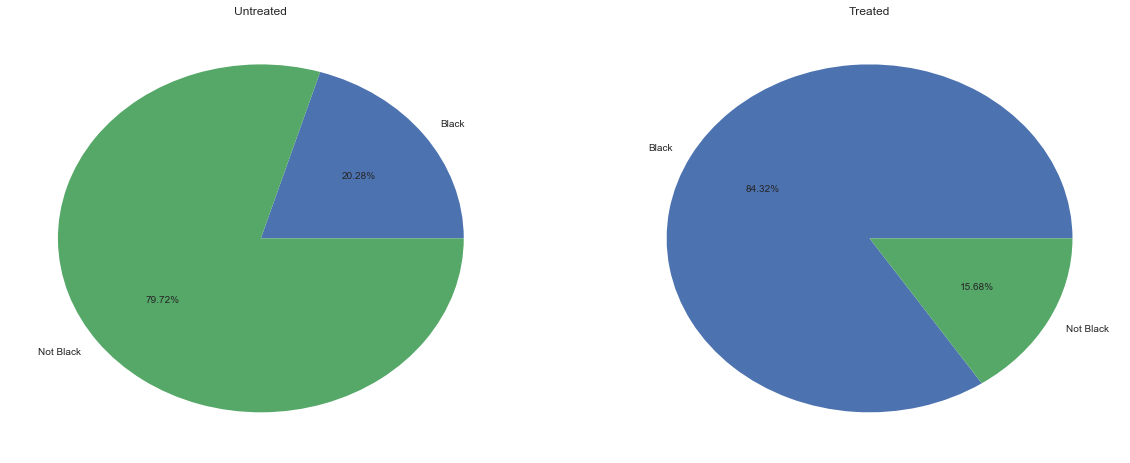

In [735]:
# Plot pie charts of the proportions of black people among both: treated and untreated people
black_probs = data.groupby(by='treat').apply(lambda x: x['black'].mean())
black_probs

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].pie([black_probs[0], 1-black_probs[0]], labels=['Black','Not Black'], autopct='%1.2f%%')
axes[0].set_title('Untreated')
axes[1].pie([black_probs[1], 1-black_probs[1]], labels=['Black','Not Black'], autopct='%1.2f%%')
axes[1].set_title('Treated')

del(black_probs)

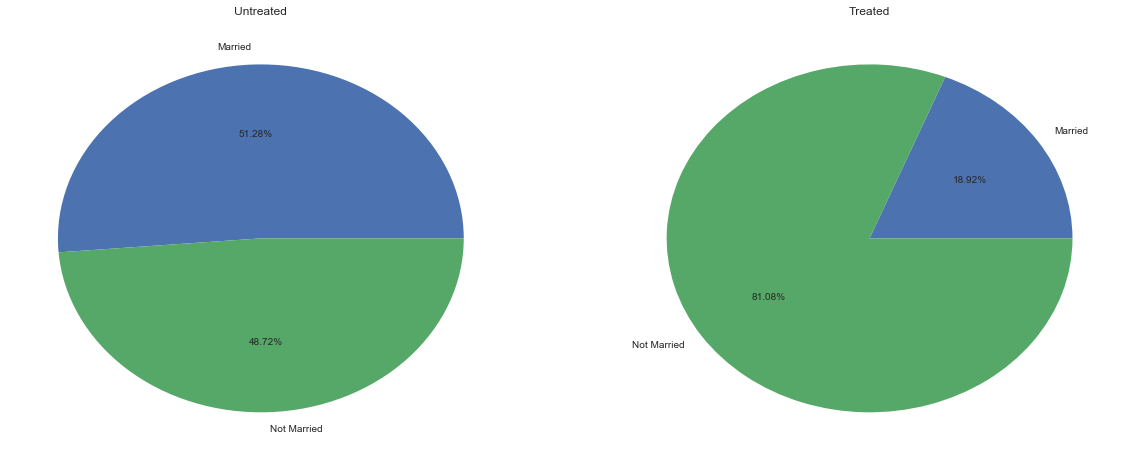

In [736]:
# Plot pie charts of the proportions of married people among both: treated and untreated people
married_probs = data.groupby(by='treat').apply(lambda x: x['married'].mean())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].pie([married_probs[0], 1-married_probs[0]], labels=['Married','Not Married'], autopct='%1.2f%%')
axes[0].set_title('Untreated')
axes[1].pie([married_probs[1], 1-married_probs[1]], labels=['Married','Not Married'], autopct='%1.2f%%')
axes[1].set_title('Treated')

del(married_probs)

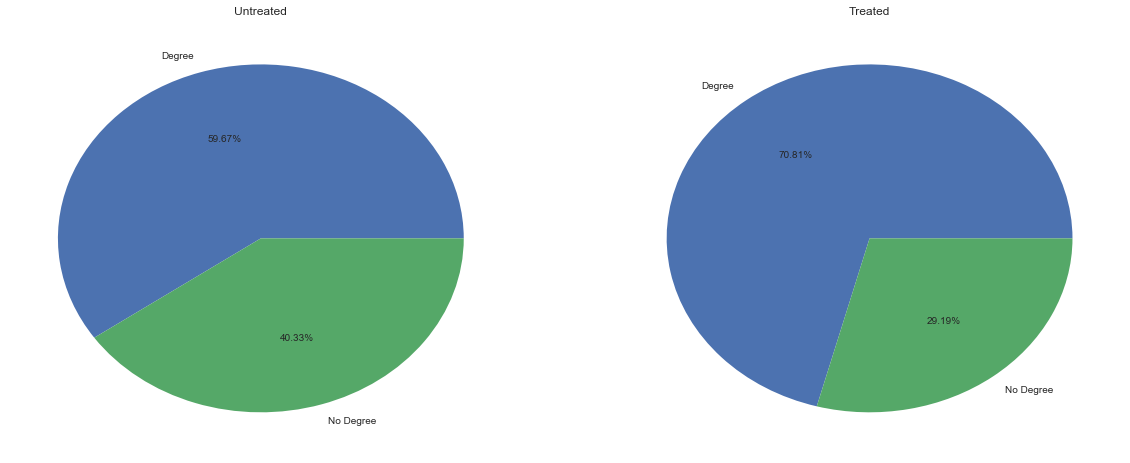

In [737]:
# Plot pie charts of the proportions of people having a degree among both: treated and untreated people
degree_probs = data.groupby(by='treat').apply(lambda x: x['nodegree'].mean())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].pie([degree_probs[0], 1-degree_probs[0]], labels=['Degree','No Degree'], autopct='%1.2f%%')
axes[0].set_title('Untreated')
axes[1].pie([degree_probs[1], 1-degree_probs[1]], labels=['Degree','No Degree'], autopct='%1.2f%%')
axes[1].set_title('Treated')

del(degree_probs)

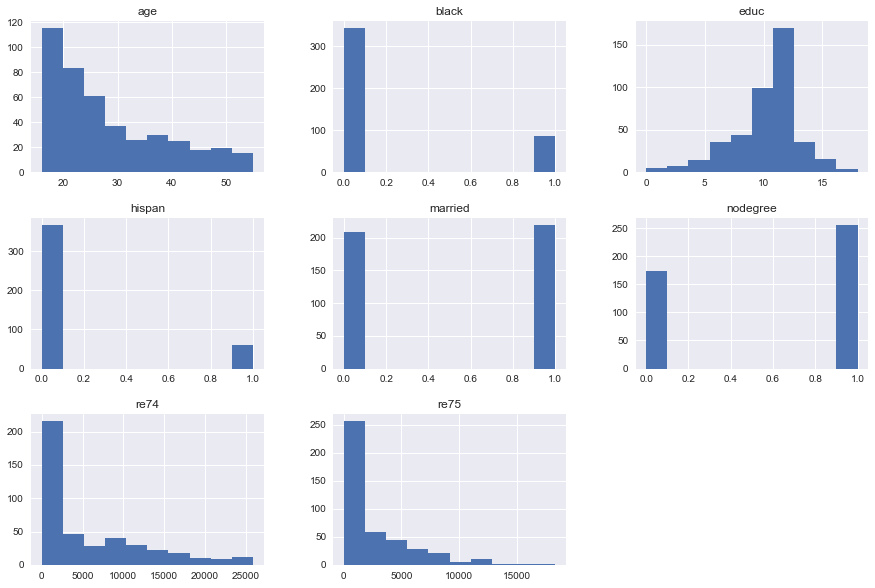

In [738]:
# Plot the distribution all variables except re78 for the untreated people
arr = data[['age', 'educ', 'black', 'hispan', 'married',
       'nodegree', 're74', 're75']].loc[data['treat'] == 0].hist(figsize=(15,10))

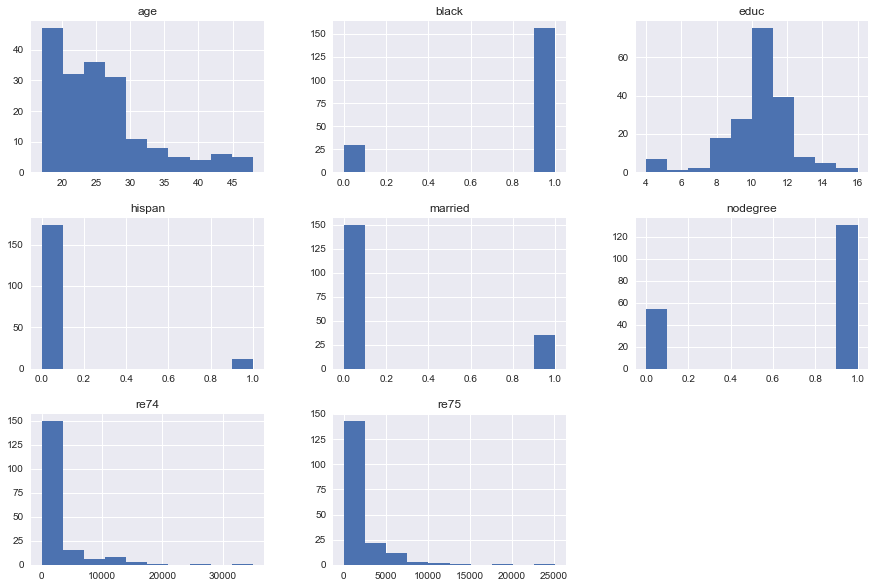

In [739]:
# Plot the distribution all variables except re78 for the treated people
arr = data[['age', 'educ', 'black', 'hispan', 'married',
       'nodegree', 're74', 're75']].loc[data['treat'] == 1].hist(figsize=(15,10))

## What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.  
The statistical descriptions of the data hightlight some facts, particulary that the number of black people is greater in the treated group than in the other one (84% vs. 20%). Moreover, the average age for treated people is 28, which is higher than the one of untreated people(25). This reflects the other fact that there more married people in the treated group than in the other one (51% vs. 18%). Not to mention that the number of people having a degree among the treated group is also greater than the one of the other group. The aforementionned observations imply that the conclusions of the "naive researcher" are meaningless, since the differences in the outcome variabe re78 may not only depend on the treatment alone, but also on the other different variables(degree, married,etc.) These covariates play a major role in the data distribution of the outcome variable. However we observe that the two groups have almost the same salary even though the treated participants are younger, less experienced and have less degrees. Hence, the treatment tend to effect positively the outcome variable for the treated group.  

### 3. A propensity score model  
Here will apply logistic regression to estimate the propensity scores of all datapoints.

In [740]:
from sklearn import linear_model
# Create a new logistic regressior 
logistic = linear_model.LogisticRegression(warm_start=True)

In [741]:
# Create the variables that we need for the logistic regression(the covariates X and the labels y)
X = data.drop(['treat','id','re78'],axis=1) #remove the treat,id and re78 columns as these should influe the covariates
y = data['treat']

In [742]:
# Apply logistic regression
logistic.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True)

In [743]:
# Save the propensity score of the datapoints in a datframe
predictions = pd.DataFrame(logistic.predict_proba(X), columns=['propensity_score_0', 'propensity_score_1'])
predictions.head(7)

,propensity_score_0,propensity_score_1
0,0.556650,0.443350
1,0.855340,0.144660
2,0.277645,0.722355
3,0.335849,0.664151
4,0.301714,0.698286
5,0.299882,0.700118
6,0.268208,0.731792


In [744]:
# Just by curiosity, we calculated the accuracy of our logistic regression
1-np.abs(y - logistic.predict(X)).mean()

0.8078175895765473

In [745]:
# Add the propensity score column to the initial dataframe
data['propensity score'] = predictions['propensity_score_1']
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


### 4. Balancing the dataset via matching  
Here we will match every datapoint from the treated group with exactly another one from the untreated group. This is done by calculating the minimal sum of absolute propensity-score differences between the two matched datapoints.

In [746]:
# Add a key column that we will use for the inner-product merge of treated and untreated people
temp_df0 = data.loc[data['treat']==0,'id,propensity score'.split(',')]
temp_df1 = data.loc[data['treat']==1,'id,propensity score'.split(',')]
temp_df0['key'] = np.zeros(len(temp_df0))
temp_df1['key'] = np.zeros(len(temp_df1))

temp_df0.head()

,id,propensity score,key
185,PSID1,0.050504,0.0
186,PSID2,0.033330,0.0
187,PSID3,0.022574,0.0
188,PSID4,0.024906,0.0
189,PSID5,0.416054,0.0


In [747]:
# Merge untreated and treated people based on the key added earlier
# Now for each untreated id and it's corresponding propensity score, there is a 'match' with every treated id and
# it's correponding propensity score (We have all possible pairs of (treated/untreated))
nodes_df = pd.merge(temp_df0,temp_df1, on='key')
nodes_df.head()

,id_x,propensity score_x,key,id_y,propensity score_y
0,PSID1,0.050504,0.0,NSW1,0.443350
1,PSID1,0.050504,0.0,NSW2,0.144660
2,PSID1,0.050504,0.0,NSW3,0.722355
3,PSID1,0.050504,0.0,NSW4,0.664151
4,PSID1,0.050504,0.0,NSW5,0.698286


In [748]:
# Add the absolute value of the difference between the two propensity scores from the merged table
# This dataframe will allow us to iterate through it and add the weighted edge between each node
# and reduce our computational cost
nodes_df['absolute propensity difference'] = np.abs(nodes_df['propensity score_x']-nodes_df['propensity score_y'])
nodes_df.head()

,id_x,propensity score_x,key,id_y,propensity score_y,absolute propensity difference
0,PSID1,0.050504,0.0,NSW1,0.443350,0.392846
1,PSID1,0.050504,0.0,NSW2,0.144660,0.094156
2,PSID1,0.050504,0.0,NSW3,0.722355,0.671851
3,PSID1,0.050504,0.0,NSW4,0.664151,0.613647
4,PSID1,0.050504,0.0,NSW5,0.698286,0.647782


In [749]:
# Create a netwrok
B = nx.Graph()
# Add nodes to the network with bipartite as parameter to create a bipartited network
B.add_nodes_from(temp_df0['id'], bipartite=0)
B.add_nodes_from(temp_df1['id'], bipartite=1)
# Create two sets of nodes for the bipartite graph
untreated_nodes = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
treated_nodes = set(B) - untreated_nodes
# Add an edge between each two nodes in the graph
# We just iterate through
for (id_x, id_y, abs_prop_diff) in zip(nodes_df['id_x'], nodes_df['id_y'], nodes_df['absolute propensity difference']):
    B.add_edge(id_x,id_y, weight = -abs_prop_diff)# we use the negative of the abs to calculate the maximum later
                                                  # which gives us the minimal sum of the absolute value

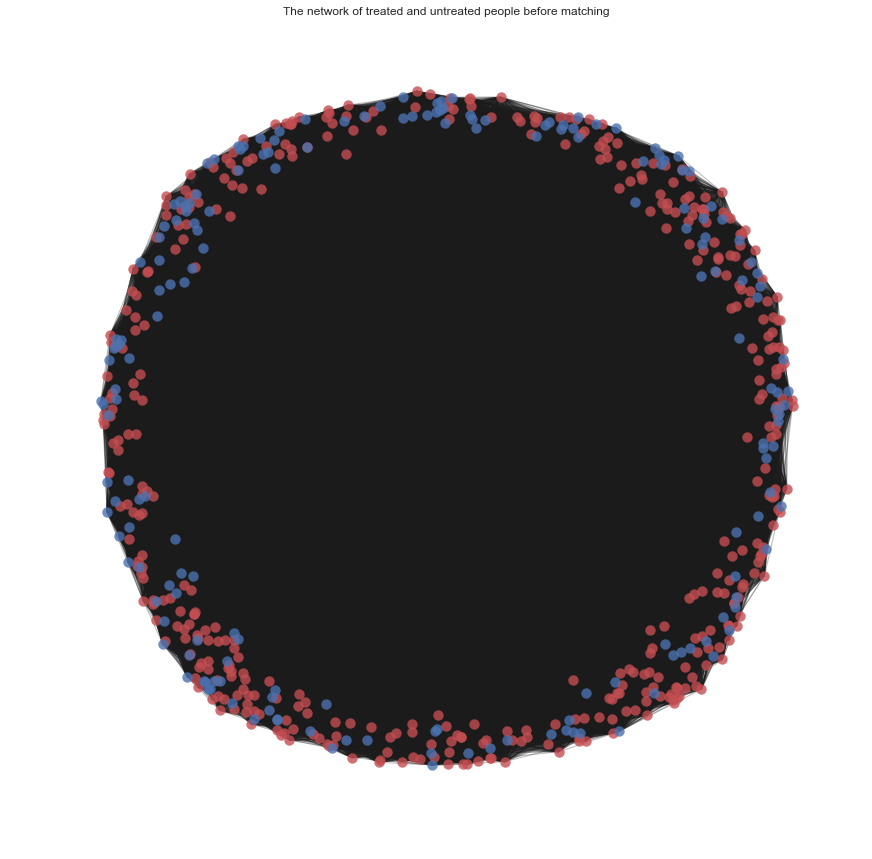

In [750]:
# Visualize the network B
fig = plt.figure(figsize=(15,15))
plt.axis('off')
plt.title('The network of treated and untreated people before matching')
pos = nx.spring_layout(B)
nx.draw_networkx_nodes(B,pos,
                       nodelist=untreated_nodes,
                       node_color='r',
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_nodes(B,pos,
                       nodelist=treated_nodes ,
                       node_color='b',
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_edges(B,pos,alpha=0.3)

In [751]:
# Calculate the maximum weight in order to determine the minimal sum of the abolute values 
mate = nx.max_weight_matching(B,maxcardinality=True)

In [752]:
# Remove duplicates from the mate dictionary
mate_network = {key: value for key, value in mate.items() if key in list(non_treated_data['id'])}

In [753]:
# Build tuples of the matched objects
tuples = []
for key, value in mate_network.items():
    tuples.append((key,value))
    
# Remove edges of all unmatched nodes from the network
for edge in B.edges():
    if edge not in tuples:
        B.remove_edge(edge[0],edge[1])
        
# Create nodes for treated and untreated people
matched_untreated_nodes = list(mate_network.keys())
matched_treated_nodes = list(mate_network.values())
match_nodes=[]

# Add last nodes to the matched nodes
for node in matched_untreated_nodes:
    match_nodes.append(node)
for node in matched_treated_nodes:
    match_nodes.append(node)

# Remove unmatched nodes from the network
for node in B.nodes():
    if node not in match_nodes:
        B.remove_node(node)

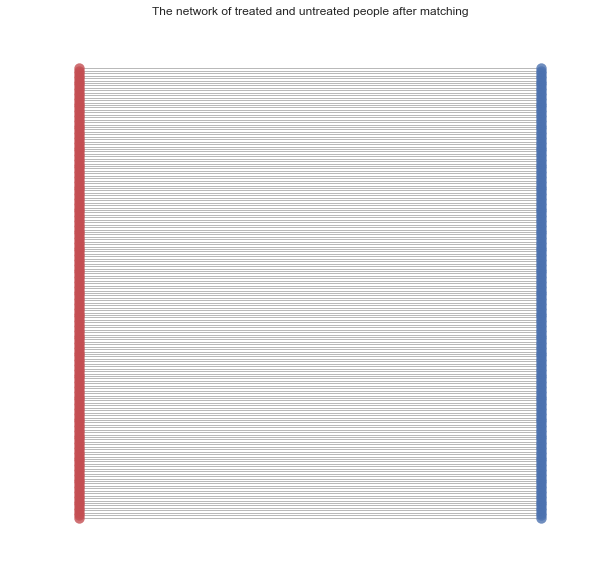

In [754]:
# This code visualizes the network after the matching
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('The network of treated and untreated people after matching')
pos = nx.spring_layout(B)
pos.update((node, (1, index)) for index, node in enumerate(matched_untreated_nodes))
pos.update((node, (2, index)) for index, node in enumerate(matched_treated_nodes))
nx.draw_networkx_nodes(B,pos,
                       nodelist=matched_untreated_nodes,
                       node_color='r',
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_nodes(B,pos,
                       nodelist=matched_treated_nodes,
                       node_color='b',
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_edges(B,pos,alpha=0.3)

We can see in the figure above, how our initial network looks like after the matching.  

In [755]:
# Add propensity score for untreated and treated people 
treated_data = data.loc[data['treat']==1,:] 
untreated_data = data.loc[data['treat']==0,:] 
treated_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


In [756]:
untreated_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity score
185,PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,0.050504
186,PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,0.033330
187,PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,0.022574
188,PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,0.024906
189,PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.416054


In [757]:
# Create a dataframe for the matched nodes and rename the index column as id_2
mate_df = pd.DataFrame.from_dict(mate, orient = 'index')
mate_df.rename(columns={0:'id_2'}, inplace=True)
# Merge treated data with the match data based on the id in the treated data and rename id_2 to non_treated_id
matched_df = pd.merge(treated_data, mate_df, left_on='id', right_index=True)
matched_df.rename(columns={'id_2':'non_treated_id'}, inplace=True)

matched_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity score,non_treated_id
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350,PSID221
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660,PSID395
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355,PSID118
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151,PSID417
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286,PSID237


In [758]:
# Merge the previous result with the data of untreated people based on id
# _x stands for treated, _y stands for untreated 
matched_df = pd.merge(matched_df, untreated_data, left_on='non_treated_id', right_on='id')
matched_df.head()

,id_x,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,...,age_y,educ_y,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y,propensity score_y
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,...,19,12,0,0,0,0,815.0550,964.9839,12059.730,0.173747
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,...,53,12,0,0,0,0,0.0000,0.0000,0.000,0.143760
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,...,20,11,1,0,0,1,0.0000,3480.3870,5495.665,0.717044
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,...,16,8,0,1,0,1,0.0000,0.0000,12242.960,0.158380
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,...,19,9,0,0,0,1,773.9104,676.7419,5647.871,0.149891


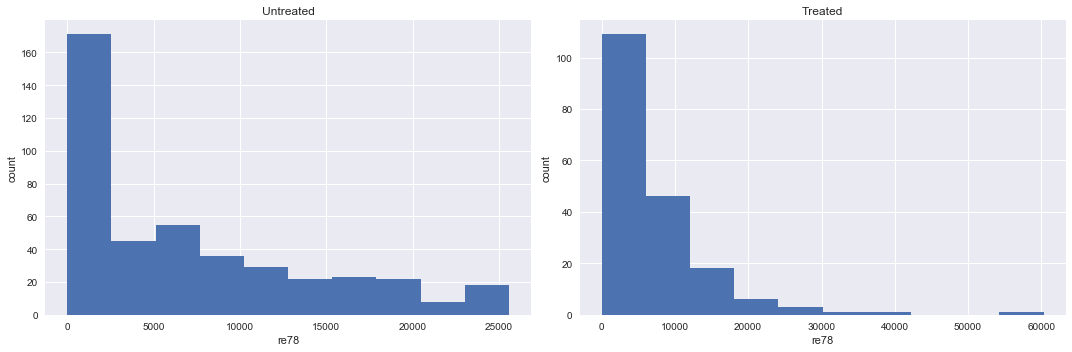

In [770]:
# Plot the outcome variable for untreated and treated people 
plt.subplot(1, 2, 1)

untreated_data['re78'].hist(figsize=[15,5])
plt.title('Untreated')
plt.xlabel('re78')
plt.ylabel('count')

plt.subplot(1,2,2)
treated_data['re78'].hist(figsize=[15,5])
plt.title('Treated')
plt.xlabel('re78')
plt.ylabel('count')

plt.tight_layout()

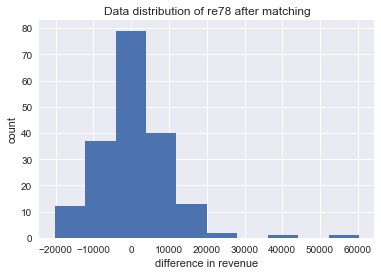

In [760]:
# Plot the difference of the outcome variance between treated and untreated people
fig, ax1 = plt.subplots()
arr = plt.hist(x=matched_df['re78_x']-matched_df['re78_y'])
ax1.set_title('Data distribution of re78 after matching')
ax1.set_xlabel('difference in revenue')
ax1.set_ylabel('count')

/Users/KhalilCherif/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


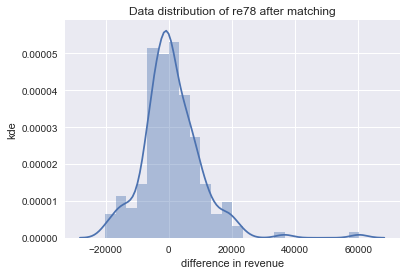

In [761]:
# Plot the distribution on the previous barplot, which is close to a nomral distribution
fig, ax1 = plt.subplots()
sns.distplot(a=matched_df['re78_x']-matched_df['re78_y'])
ax1.set_title('Data distribution of re78 after matching')
ax1.set_xlabel('difference in revenue')
ax1.set_ylabel('kde')

### After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control)  
After the matching, we have plotted the outcomes (`re78`) and their differences between the two groups, and as we can see above the result is a normal distribution that is more balanced than before the matching, which means that the outcome gaps are more equilibrated than before.

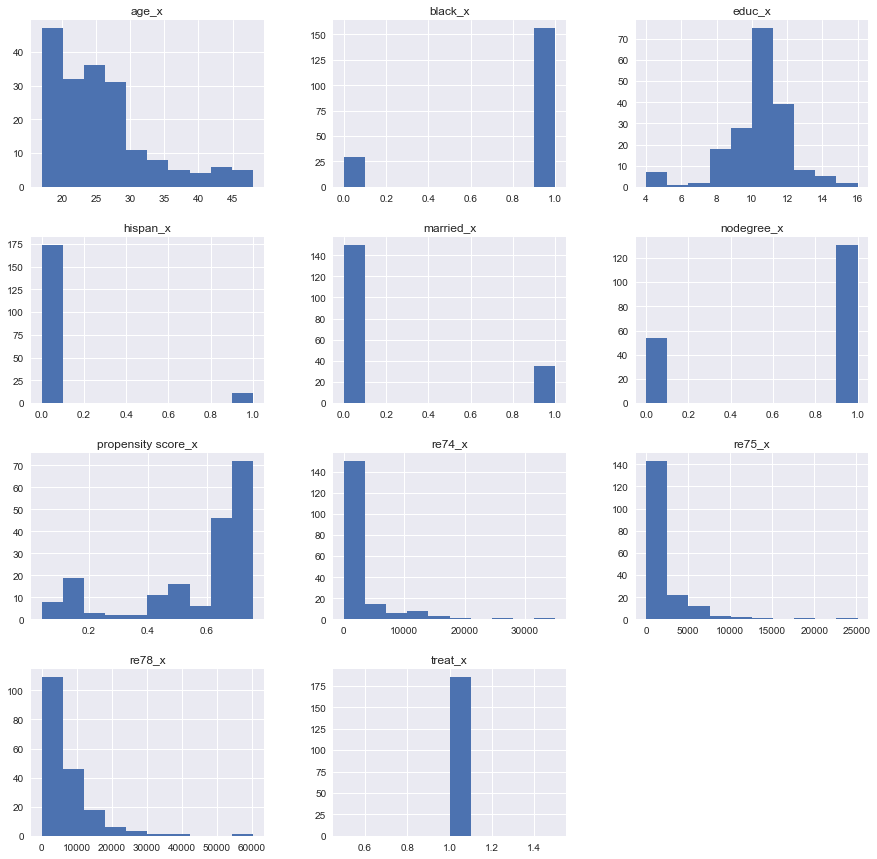

In [762]:
# Plot the covariates distributions of the treated people after matching
arr = matched_df.iloc[:,:12].hist(figsize=(15,15))

In [763]:
# Find columns that end with '-y'
cols = pd.Series(matched_df.columns)
cols_y = cols[cols.apply(lambda x: x.endswith('_y'))]

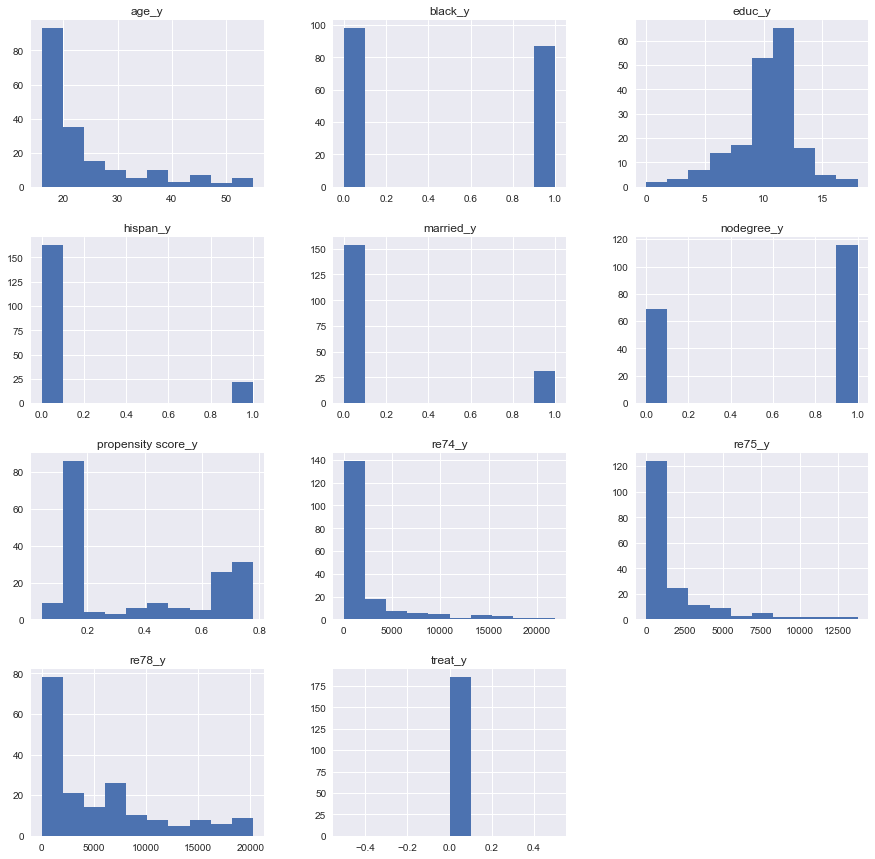

In [764]:
# Plot the covariates distributions of the untreated people after matching
arr = matched_df[cols_y].hist(figsize=(15,15))

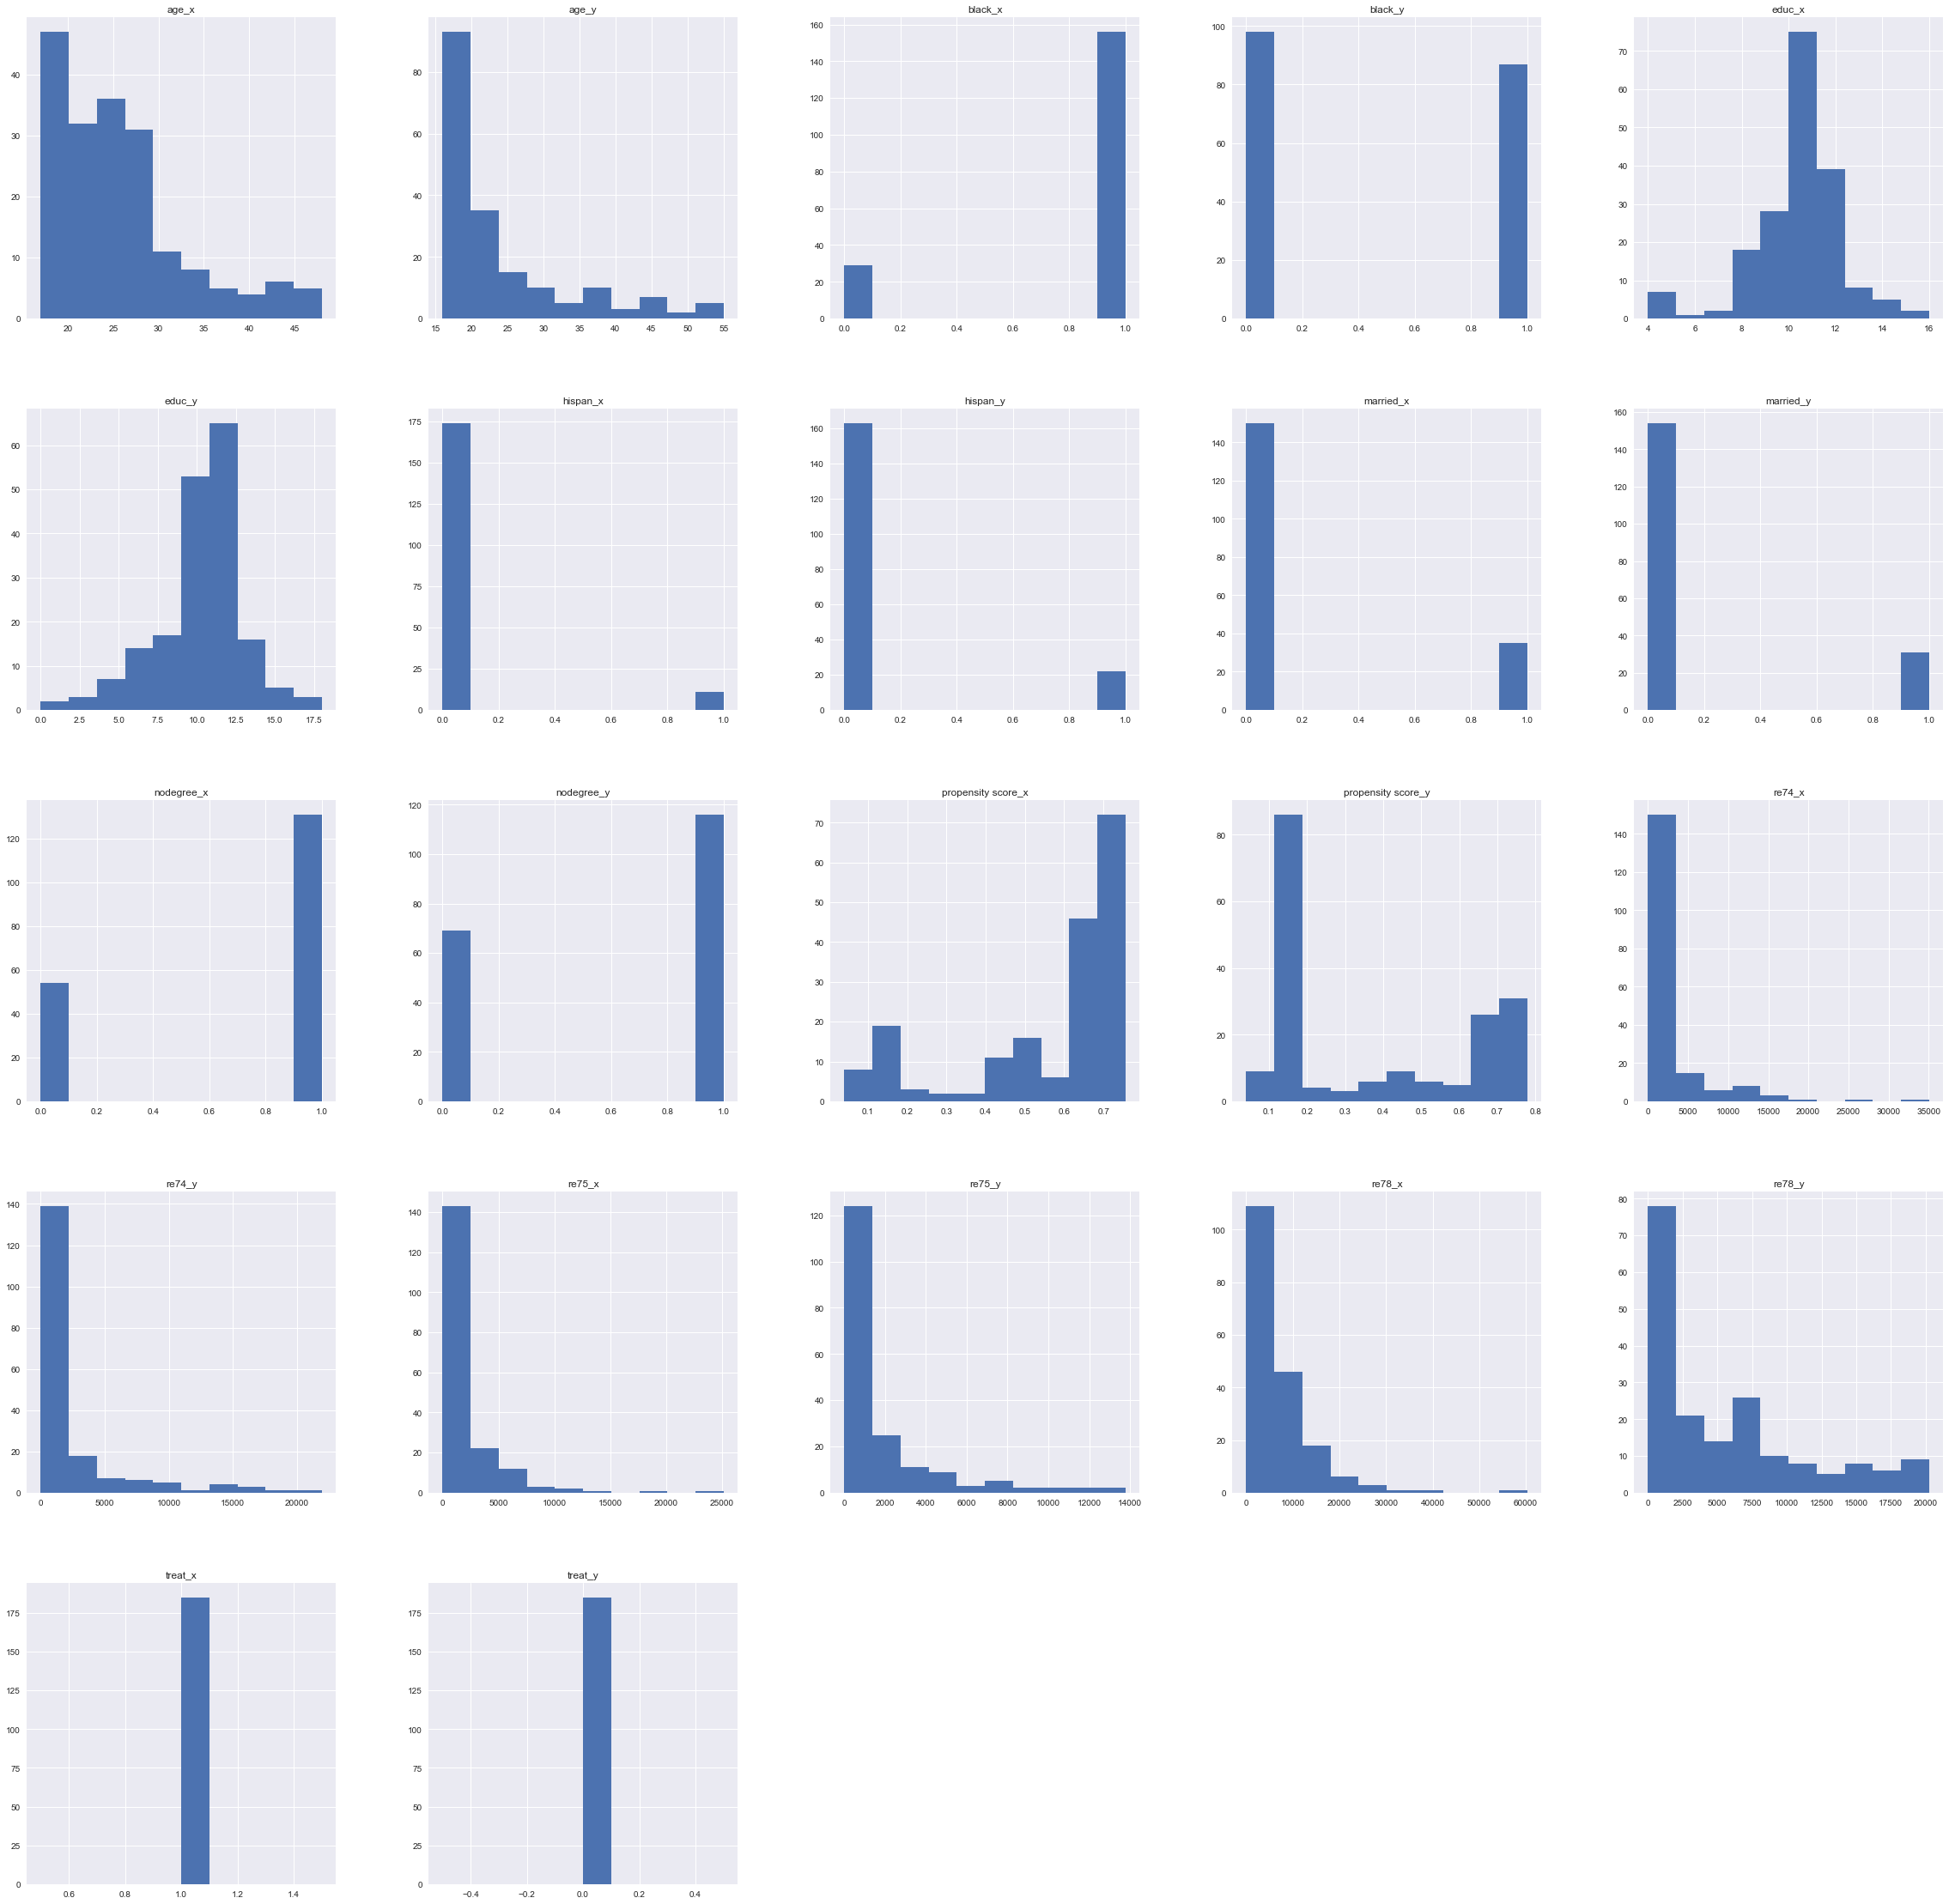

In [765]:
# Plot the distributions of the the covariates for treated, untreated people after the matching
arr = matched_df.hist(figsize=(40,40))

### What do you observe? Are you closer to being able to draw valid conclusions now than you were before ?  
The covariates are more balanced after the matching, but there still are some variables which show clear differences such as `black` see (`black_x` vs. `black_y`). Through the matching we have improved the balance of some covariates distributions, but we still cannot deduct any significant conclusion.

## 5. Balancing the groups further  

### Are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?  
No, we are still not completely satisfied with our matching, because the dataset can be better balanced by setting a threshold value for the matched pairs, which means that we only consider the matches that have an absolute difference that is lower than a certain threshold $\epsilon$ (i.e $\epsilon = 0.01$). The almost balanced dataset that we obtained so far stops us from getting valid conclusions, since it still include covariates with considerable differences in the distribution. That is why the aforedescribed matching strategy with the additional threshold might help us to get better insights on the treatment results. 

### Threshold $\epsilon = 0.01$

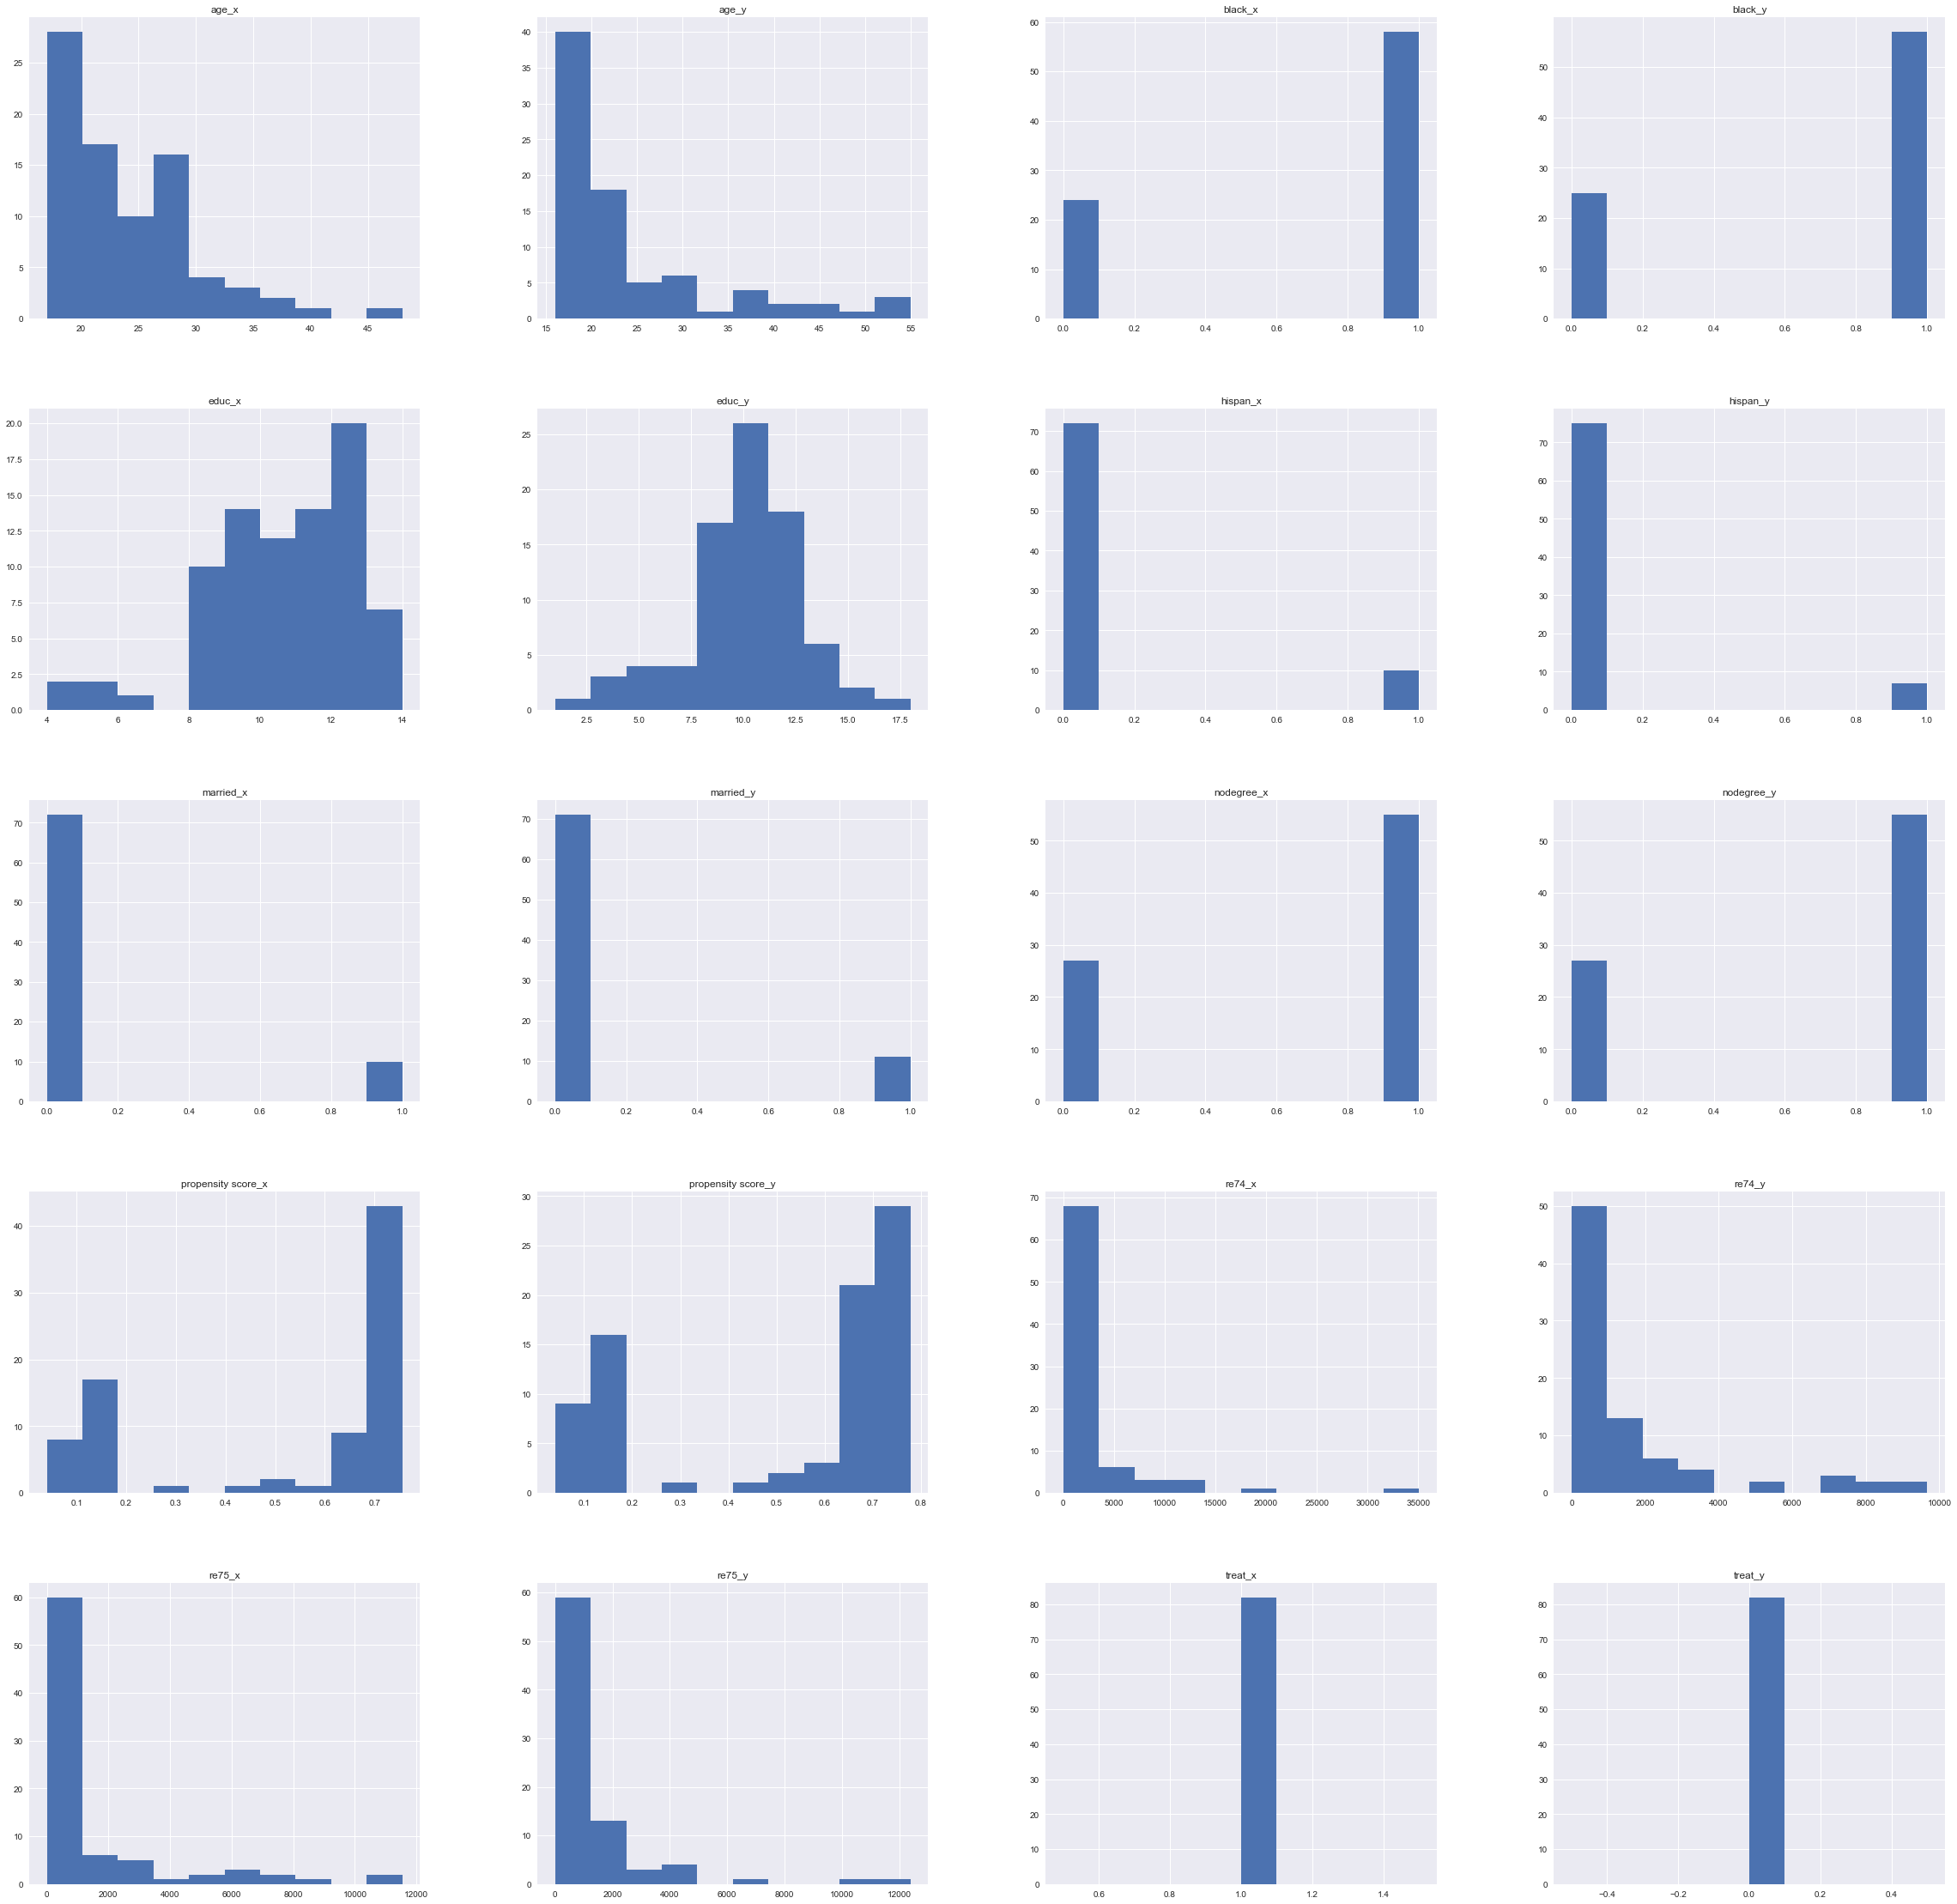

In [767]:
# Plot the differences of values of the covariates 
arr = matched_df.loc[(matched_df['propensity score_x']-matched_df['propensity score_y'])<0.01,:].drop(['re78_x','re78_y'], axis=1).hist(figsize=(40,40))

The plots figured atop show how the covariates now after using the threshold value $\epsilon = 0.01$ are better balanced as never before.

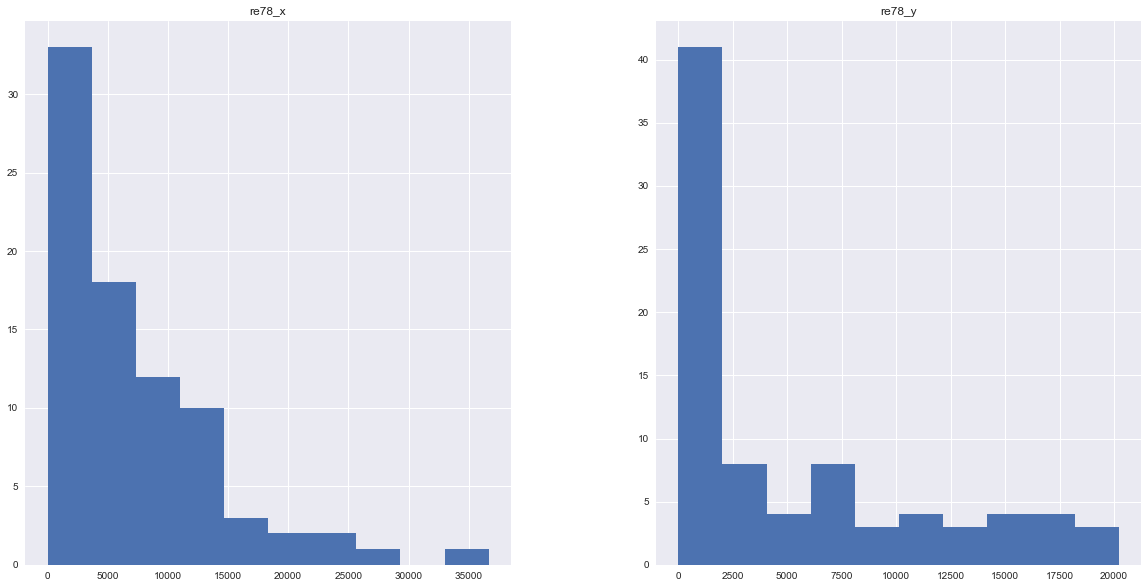

In [768]:
# Plot the outcome variable re78 with re78_x for the treated group and re78_y for the untreated one
arr = matched_df[['re78_x','re78_y']].loc[(matched_df['propensity score_x']-matched_df['propensity score_y'])<0.01].hist(figsize=(20,10),bins=10)

In [769]:
# Show basic statistical measures for the treated and untreated groups
matched_df[['re78_x','re78_y']].loc[(matched_df['propensity score_x']-matched_df['propensity score_y'])<0.01].describe()

,re78_x,re78_y
count,82.000000,82.000000
mean,6772.283851,5002.050371
std,7138.499010,6140.840339
min,0.000000,0.000000
25%,610.311050,0.000000
50%,5297.350500,1944.688500
75%,10734.085000,8615.145750
max,36646.950000,20243.380000


The statistical measures and the plots of the outcome between the two groups(`re78_x` stands for the treated group and `re78_y` represents the untreated group) uncovers many ambiguities about the effictiveness of the treatment. One can clearly see that the treated people have an averagely better income than the untreated ones(`6018`vs`4785`) and can get higher salaries up to 36000 Dollars. Hence, the job training program seems to have a positive impact on its participants.
### Conclusion:  
This exercise teaches us how important it is, to have a deeper look on the data and not overlook on valuable insights that might get missed through "naive analysis". Morever, the measures that we took such as matching on propensity score and threshold matching have helped us a lot to balance the distribution of the covariates and get a better overview on the outcome variable `re78`, which resulted in better observations and consequently sound conclusions. 

## Question 2: Applied ML

In this part, we are trying to classify a corpus text in 20 different groups, the corpus is taken from the datasets provided by sklearn, we will train a model (a random forest in our case) to classify the different texts into the best group that describes them 

In [481]:
# the dataset is 20newgroups, which we will fetch from sklearn.datasets
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint

# TfidfVectorizer will be the processing method we will use to transfor our texts into a matrice form to train our model
from sklearn.feature_extraction.text import TfidfVectorizer

# train_test_split will allow us to split our data into train, validation and test data
from sklearn.cross_validation import train_test_split

# The DecisionTreeClassifier is basically a random forest classifier with only one tree, we will see the difference
# in performance by using only one tree and a bunch of trees from which we will average the result.
from sklearn.tree import DecisionTreeClassifier

In [482]:
# newsgroups contains the the 20newsgroups dataset that we fetched
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

In [483]:
# vectorizer is the Tfidf method we will use, we also decided to exclude the known stop_words like 'the', 'know' etc...
# This exclusion of stop_words improves drastically the precision of our classifier
vectorizer = TfidfVectorizer(stop_words = 'english')

In [ ]:
# When using vectorizer to transform our data into matrix, sklearn will output a sparse matrix, scipy.sparse
# will allow us to use some predefined method to manipulate this kind of objects (we will only use it to append 2 sparse matrices)
import scipy.sparse

In [484]:
# X_train is our training set, it contains 80% of the data
# X_val is our valdation set, we will use it to assess the performance of our classifier through our different configurations
# X_test is the final set we will use to assess the performance, it will be used once to avoid overfitting and to get
# a good approximation of our precision (we will use cross_validation at the end to get the best approximation of our performance)
# X_temp is just a temporary variable that contains 20% of the data that we will split 50-50 to get 10% for the
# validation set and 10% for the testing set
# Finally X_fit is the training set and the validation set merged to assess by cross_validation the precision of our classifier
# We will after that use this classifier on our test set that didn't play a role during the process to verify the veracity
# of our estimation

# Note: We are asked to perform the Tfidf method before splitting, which is done in our case, but we still think that
# we should apply this method to the validation set and testing set after performing it on the training set, this represents better
# how it would be done in real life, since we would have to classify texts after training our model, so creating
# the Tfidf matrice with the data we will try to classify is kind of cheating. But this what is asked, you can find
# below how the train, test and validation sets would have been created.

#X_train = vectorizer.fit_transform(X_train)
#X_test = vectorizer.transform(X_test)
#X_val = vectorizer.transform(X_val)

X_train, X_temp, y_train, y_temp = train_test_split(vectorizer.fit_transform(newsgroups.data), newsgroups.target, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)
X_fit = scipy.sparse.vstack([X_train, X_val])
y_fit = np.append(y_train, y_val, axis=0)

# We delete X_temp and y_temp because they are just temporary variables, by doing so we will free some memory
del(X_temp, y_temp)

In [388]:
# We will create a simple tree and train it to see how it performs on our dataset, we will then plot the corresponding
# confusion matrice and the classification report.
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [389]:
# The predictions of the simple tree on our validation set
val_predictions = dtree.predict(X_val)

In [390]:
# classification_report will allow us to print the precision of our model, the recall, the f1_score to see how well
# it performs
# confusion_matrix will create the confusion_matrix of our model
from sklearn.metrics import classification_report, confusion_matrix

In [391]:
# We are now printing our classification_report and our confusion_matrix
# As expected, we got a poor performance level using the simple tree classification (50% precision, 49% recall)
print(confusion_matrix(y_val,val_predictions))
print('\n\n')
print(classification_report(y_val, val_predictions))

[[29  0  0  1  1  3  1  7  2  0  2  3  4  3  2  8  7  2  5 13]
 [ 0 48  6  6  4 11  3  7  0  1  0  1  6  1  4  2  0  0  1  2]
 [ 2  8 34 16  1  7  2  6  1  2  0  2  3  1  1  0  1  1  1  1]
 [ 1  9 10 35 12  3  8  6  2  3  0  1  7  4  3  1  1  0  0  0]
 [ 2  3  5 10 30  1  6 10  1  1  0  5  5  2  1  1  1  0  2  0]
 [ 0  8  8  5  1 51  1  1  2  3  0  0  4  1  1  0  1  2  0  1]
 [ 1  2  0  2  3  1 65  5  2  4  3  2  3  1  2  0  0  0  0  0]
 [ 0  3  3  1  2  3  7 56  7  3  0  0  3  1  1  2  2  1  2  1]
 [ 1  0  2  1  1  2  4 14 63  1  1  0  2  4  1  0  3  2  1  1]
 [ 1  2  1  1  0  0  0  9  0 54 12  1  2  2  0  0  0  3  0  2]
 [ 0  1  0  1  0  1  2  7  2 14 60  2  1  0  0  0  0  1  0  2]
 [ 1  5  0  0  4  1  3  6  4  0  2 53  4  0  1  0  5  1  3  2]
 [ 1  4  4  2  3  2  4 13  1  3  1  1 54  5  5  2  3  1  3  0]
 [ 0  5  1  0  2  1  1  7  1  2  5  2  6 61  6  1  2  2  2  1]
 [ 0  2  2  3  2  0  0  7  1  3  1  3  4  3 59  3  1  0  4  1]
 [11  1  0  0  1  1  1  5  0  1  0  0  1  5  2 56  3  5

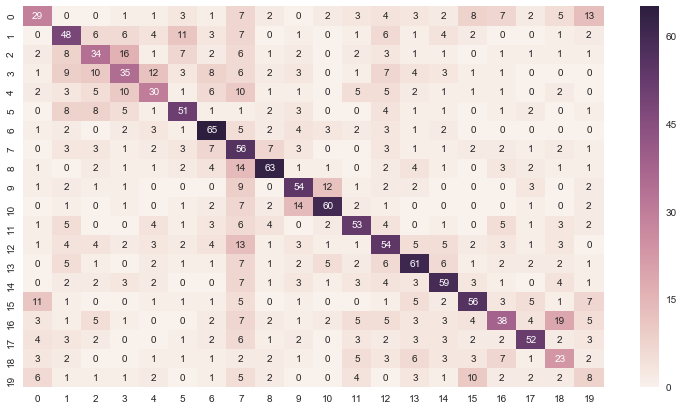

In [392]:
# The confusion_matrix is not very clear, so we will plot it using heatmap to better visualize how each category
# was classified
plt.figure(figsize=(13,7))
sns.heatmap(confusion_matrix(y_val, val_predictions), annot=True)

Now we will try to find the best parameters for our random forest classifier using grid search cross validation.
Once found, we will use this classifier to classify our testing data and estimate our precision

In [393]:
# Now we will import our RandomForestClassifier and joblib which we will use to save python objects. 
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

In [398]:
# Importing the grid search cross validation method to use
from sklearn.model_selection import GridSearchCV

In [399]:
# importing the cross validation method to estimate on the best classifier found what is the precision
# Recall that cross validation gives a good estimation of the performance of your model, using a test set is just good
# to avoid heavy computation, but the best estimation we can get is from a cross validation
from sklearn.cross_validation import cross_val_score

In [400]:
# Now we create a list for the 2 parameters we want estimate their best value, the number of trees and their depths.
params = {'n_estimators': np.arange(start=200, stop=900, step=100), 'max_depth': np.arange(1,3*int(np.log(X_train.shape[1])))}

In [401]:
params

{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 'n_estimators': array([200, 300, 400, 500, 600, 700, 800])}

In [402]:
# initialising the random forest classifier we will use (can be avoided)
rfc_estimator = RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [404]:
# We do not recommend the user to run this cell if they didn't download the file 'GS_CV_800_32.pkl', because
# if the file is not found, this cell will run the code to create it and it takes approximately 3.5 hours to be done
try:
    GS_CV = joblib.load('GS_CV_800_32.pkl')
except:
    GS_CV = GridSearchCV(rfc_estimator, param_grid=params)
    GS_CV.fit(X_val, y_val)
    joblib.dump(GS_CV, 'GS_CV_800_32.pkl')

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([200, 300, 400, 500, 600, 700, 800]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [405]:
# Here are the best parameters that were found
GS_CV.best_params_

{'max_depth': 31, 'n_estimators': 800}

In [406]:
# We are creating a dataframe to visualize how was the performance for each combination of depth and n_estimators
# It seems like the higher the depth is, the better it performs for this set
# We already know that the higher the number of estimators is the better it performs since the increase of
# this parameters does not increase the overfitting and it will best evaluate different models with different importances
# for the different parameters and average everything to get a better classification
res_df = pd.DataFrame(GS_CV.cv_results_['mean_test_score'].reshape((len(params['n_estimators']),len(params['max_depth']))), index=params['n_estimators'], columns=params['max_depth'])
res_df.index.name = 'n_estimators'
res_df.columns.name = 'max_depth'
res_df

max_depth,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
n_estimators,,,,,,,,,,,,,,,,,,,,,
200,0.190981,0.186737,0.195756,0.186207,0.185676,0.163395,0.175597,0.274271,0.265782,0.278515,...,0.379310,0.364987,0.384085,0.395225,0.390451,0.392573,0.412202,0.422812,0.420690,0.419098
300,0.436605,0.430239,0.423342,0.416446,0.423873,0.445093,0.446154,0.451989,0.454642,0.453050,...,0.491777,0.500265,0.478515,0.482759,0.496021,0.500796,0.497082,0.499204,0.499204,0.482759
400,0.494960,0.497613,0.506631,0.505570,0.515119,0.517241,0.489125,0.506101,0.506101,0.505040,...,0.506101,0.526790,0.529443,0.515119,0.533687,0.499735,0.519363,0.520424,0.522546,0.523077
500,0.533687,0.534748,0.512997,0.525729,0.523607,0.539523,0.534748,0.534748,0.542706,0.511936,...,0.544828,0.513528,0.524668,0.530504,0.540053,0.545889,0.541114,0.544828,0.528912,0.534748
600,0.543767,0.545889,0.534218,0.549072,0.553316,0.529443,0.525199,0.543767,0.542706,0.544828,...,0.544828,0.551724,0.555968,0.560743,0.531565,0.543236,0.544297,0.554377,0.551724,0.562865
700,0.560743,0.538992,0.546950,0.549602,0.546419,0.544828,0.553316,0.561273,0.536340,0.537931,...,0.536340,0.544828,0.550663,0.557029,0.550663,0.548011,0.558090,0.541114,0.555968,0.562334
800,0.556499,0.554377,0.555438,0.564987,0.533156,0.550133,0.558621,0.558090,0.557029,0.564987,...,0.562334,0.558090,0.567109,0.552785,0.545358,0.562334,0.555968,0.564987,0.560743,0.564987


In [ ]:
# Just by curiosity we ceated a random forest classifier with 1000 estimators and no constraint on depth
# The result was quite impressive once tested on the test set, 93% precision, 92% recall !
# Since the computation takes some minutes, we decided to save our object in 1000_no_depth_rfc.pkl, available to download
# This block will try to first open the file and fetch from it the object, if the file is not found, it will run it
# so that the object is available for the user, it will also create a file containing the object
try:
    rfc = joblib.load('1000_no_depth_rfc.pkl')
except:
    rfc = RandomForestClassifier(n_estimators=1000)
    rfc.fit(X_train, y_train)
    joblib.dump(rfc, '1000_no_depth_rfc.pkl')
    
# Here we predict the predict the labels for our validation_set using our random forest classifier
rfc_predictions = rfc.predict(X_val)

In [486]:
rfc_test_predictions = rfc.predict(X_test)


In [489]:
print(confusion_matrix(y_test,rfc_test_predictions))
print('\n\n')
print(classification_report(y_test, rfc_test_predictions))

[[ 64   0   1   0   0   1   0   6   1   0   0   0   1   0   0   3   0   0
    0   0]
 [  1  91   3   1   0   2   1   2   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   1  94   1   1   0   0   3   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  1   1   1  99   1   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   0   0   3  82   0   0   3   0   0   0   0   2   0   0   0   0   0
    0   0]
 [  0   1   1   1   0 104   0   1   0   0   0   1   0   0   0   0   0   0
    0   0]
 [  0   0   1   1   1   0  83   4   0   0   1   0   1   0   1   0   0   0
    0   0]
 [  0   0   1   1   0   0   0 107   2   1   0   0   0   0   0   0   0   0
    0   0]
 [  0   1   0   0   0   0   1   2  83   1   0   1   1   0   0   0   0   1
    0   0]
 [  0   0   0   0   0   0   0   7   0 106   0   1   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   1   0   0   2   0   2  95   0   0   0   0   0   0   1
    0   0]
 [  2   0   0   0   0   1   0   2   0   0   0  97   0   0   0   0

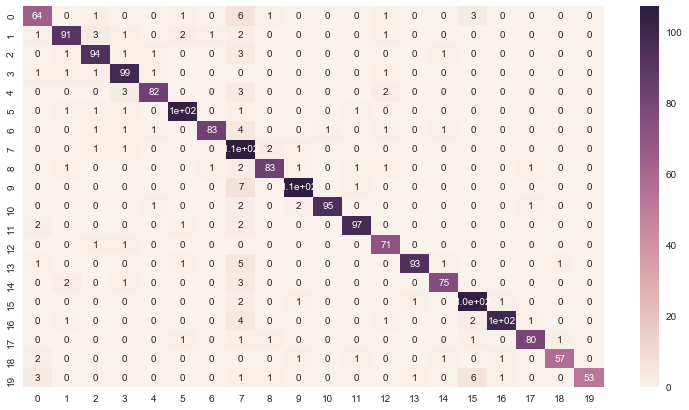

In [495]:
plt.figure(figsize=(13,7))
sns.heatmap(confusion_matrix(y_test,rfc_test_predictions), annot=True)

In [555]:
from sklearn.model_selection import PredefinedSplit

In [567]:
# This a small example on how we used the predefined split to test during the grid search cross validation our
# classifier on the validation set and not on random one chosen by the method
# As we can see, the indices for which there is a -1 value are always used to train, we can put zeros for the
# validation set so that it will only use the validation set values to estimate the precision, and -1 for 
# training set to use it to train the model, we do not think it's the best way to estimate the performance of the model
# since it will certainly overfit on the validation set, resulting on a best estimator for the validation set and not
# for the entire set in general, but this what is asked.
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
test_fold = [0, -1, -1, -1]
ps = PredefinedSplit(test_fold)

In [570]:
# As we can see, we put -1 for the indices from 1 to 3, so they were used for the training set and 0 for the indice 0
# so it was used for the testing set
for elem in ps.split(X):
    print('Train: {} || Test: {}'.format(elem[0], elem[1]))


(array([1, 2, 3]), array([0]))


In [571]:
# an instance of a random forest classifier
rfc_estimator = RandomForestClassifier()

In [605]:
# fit_fold contains -1 for all the indices of the X_fit set that comes from the training set and 0s for all indices
# that comes from the validation set (recall that X_fit is the validation set appended from the right to the training set)
fit_fold = np.append(np.ones(X_train.get_shape()[0])*(-1) , np.zeros(X_val.get_shape()[0]))

In [611]:
# Since we found that the higher is the depth and the number of estimators the better the performance is, we decided
# to initialise new values for params, higher than the previous ones, to see if there is a best choice of parameters
params = {'max_depth': np.logspace(start=0, stop=3, num=10), 'n_estimators': [500, 600, 700, 800, 900, 1000]}

In [ ]:
# Since the set of parameters we are testing here includes the best parameters found in the previous computation
# we decided to save the result in the same variable (GS_CV), in the worst case we will get the previous estimator.
# The cimputation takes a lot of time also, so the user is recommended to download the file.
try:
    GS_CV = joblib.load('GS_CV_final.pkl')
except:
    GS_CV = GridSearchCV(rfc_estimator, param_grid=params,cv=PredefinedSplit(fit_fold))
    GS_CV.fit(X_fit, y_fit)
    joblib.dump(GS_CV, 'GS_CV_final.pkl')

In [612]:
## This the output of the previous run

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([    1.     ,     2.15443,     4.64159,    10.     ,    21.54435,
          46.41589,   100.     ,   215.44347,   464.15888,  1000.     ]), 'n_estimators': [500, 600, 700, 800, 900, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [627]:
# Best estimator is our best estimator found from the previous run
best_estimator = GS_CV.best_estimator_

In [628]:
# This the score of the best etimator (note that this is a different metrics from the one we are using which is precision)
GS_CV.best_score_

0.67586206896551726

In [630]:
# This is the function used to evaluate the score
GS_CV.scorer_

<function sklearn.metrics.scorer._passthrough_scorer>

In [618]:
# Now we will predict the categories for the test set
test_pred = best_estimator.predict(X_test)

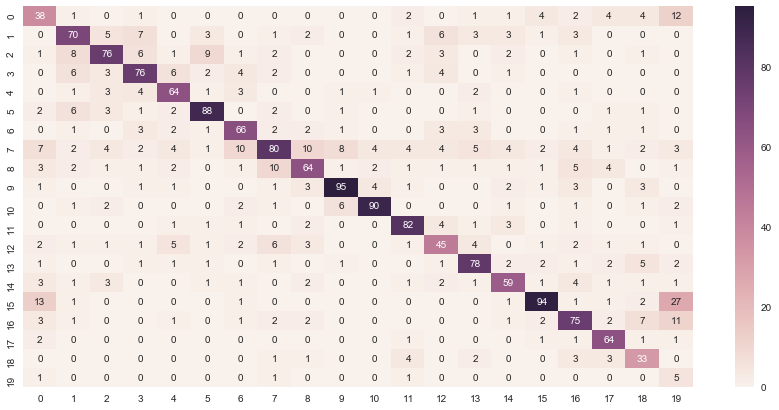

In [623]:
# Here is the heatmap for the our prediction
plt.figure(figsize=(15,7))
sns.heatmap(confusion_matrix(test_pred, y_test), annot=True)

In [624]:
# As we can see, the precision is not really good compared to the estimator with 1000 estimators and None as depth.
print(confusion_matrix(y_test,test_pred))
print('\n\n')
print(classification_report(y_test,test_pred))

[[38  0  1  0  0  2  0  7  3  1  0  0  2  1  3 13  3  2  0  1]
 [ 1 70  8  6  1  6  1  2  2  0  1  0  1  0  1  1  1  0  0  0]
 [ 0  5 76  3  3  3  0  4  1  0  2  0  1  0  3  0  0  0  0  0]
 [ 1  7  6 76  4  1  3  2  1  1  0  0  1  1  0  0  0  0  0  0]
 [ 0  0  1  6 64  2  2  4  2  1  0  1  5  1  0  0  1  0  0  0]
 [ 0  3  9  2  1 88  1  1  0  0  0  1  1  1  1  0  0  0  0  0]
 [ 0  0  1  4  3  0 66 10  1  0  2  1  2  0  1  1  1  0  0  0]
 [ 0  1  2  2  0  2  2 80 10  1  1  0  6  1  0  0  2  0  1  1]
 [ 0  2  0  0  0  0  2 10 64  3  0  2  3  0  2  0  2  0  1  0]
 [ 0  0  0  0  1  1  1  8  1 95  6  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  4  2  4 90  0  0  0  0  0  0  0  0  0]
 [ 2  1  2  1  0  0  0  4  1  1  0 82  1  0  1  0  0  1  4  1]
 [ 0  6  3  4  0  0  3  4  1  0  0  4 45  1  2  0  0  0  0  0]
 [ 1  3  0  0  2  1  3  5  1  0  0  1  4 78  1  0  0  0  2  0]
 [ 1  3  2  1  0  0  0  4  1  2  1  3  0  2 59  1  1  0  0  0]
 [ 4  1  0  0  0  0  0  2  1  1  0  0  1  2  1 94  2  1

In [643]:
# Since it was better to use None as depth, we decided to run a cross validation to estimate our score
# Since we already used our testing set previously, we created another train, validation and test sets
# It is the same code as previously
X_train, X_temp, y_train, y_temp = train_test_split(vectorizer.fit_transform(newsgroups.data), newsgroups.target, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)
X_fit = scipy.sparse.vstack([X_train, X_val])
y_fit = np.append(y_train, y_val, axis=0)
del(X_temp, y_temp)

In [644]:
#final_GSCV = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': np.arange(700, 1200, 100)}, cv=5, scoring='accuracy')


In [651]:
# The scores variable contains the different estimation for fitting three different sets with distinct test data
# and evaluating the score for the different test sets, a 3-fold cross validation.
# This evaluation takes a long time so just skip it, you will find the results hard_coded in the two cells below
scores = cross_val_score(RandomForestClassifier(n_estimators=1000), X_fit, y_fit)

In [652]:
# As we can see, the scores are a little better when using n_estimators = 1000 and depth = None than the results
# we obtained during the grid search cross validation where we attained a score of 0.675
# So increasing the n_estimators and the max_depth will result in a heavy improve of the computational cost for a
# slight increase in the mean accuracy (the score method of the random forest classifier)
# So maybe we should just use the set-up with 700 estimators and a 1000 as max_depth
scores , scores.mean() , scores.std()

array([ 0.68514921,  0.68789809,  0.67463691])

In [ ]:
# This is the scores we found in case you run the previous cells and want to skip this run
hard_coded_scores = np.array([0.68514921,  0.68789809,  0.67463691])
hard_coded_scores , hard_coded_scores.mean() , hard_coded_scores.std()

In [653]:
# We still have to check what happened during evaluating the last test set, where we reached a 93% precision and 92% recall
# So we decided to fit a new random forest classifier with the same set-up (1000 estimators no depth) for which,
# we know from the previous computation that it reaches a 68% accuracy on average

try:
    new_rfc = joblib.load('1000_no_depth_rfc_final.pkl')
except:
    new_rfc = RandomForestClassifier(n_estimators=1000)
    new_rfc.fit(X_fit, y_fit)
    joblib.dump(rfc, '1000_no_depth_rfc_final.pkl')


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [654]:
# Now that we fitted our model, let's see if it reaches a precision and recall on the test set as before, or if it was
# just luck du to the test set we randomly chose.
new_rfc_pred = new_rfc.predict(X_test)
print(confusion_matrix(y_test,new_rfc_pred))
print('\n\n')
print(classification_report(y_test,new_rfc_pred))

print('It seems like it was only luck at the previous step, but since we saved everything why don\'t we just\n retrieve the lucky random forest classifier we created and test it on a totally new test set ?')
print('Of course it will be a little biased because almost surely a lot of the data from the new test set was used to create the classifier in the first place')

[[43  0  0  0  0  0  1  4  1  0  0  0  1  0  1 11  1  3  0  5]
 [ 0 53  7  3  2 10  3  3  3  1  0  0  1  1  1  0  0  0  0  0]
 [ 0  3 83 10  2  4  1  7  4  0  1  0  2  1  1  0  0  0  0  0]
 [ 0  3 11 74  4  1  4  1  0  0  0  0  2  1  1  0  0  0  0  0]
 [ 0  0  5  5 56  4  4  7  0  0  1  1  1  0  0  0  1  0  0  0]
 [ 0  6  6  0  1 76  1  1  0  1  0  0  0  0  0  0  0  0  0  1]
 [ 0  3  2  2  3  2 90  1  0  0  0  1  2  1  4  1  0  0  0  1]
 [ 2  1  0  0  0  1  0 84  8  0  0  0  1  2  3  0  2  0  0  1]
 [ 1  0  1  0  0  1  6 13 62  2  0  1  1  2  1  1  1  0  3  0]
 [ 1  0  0  0  0  0  1  5  4 85  9  1  0  1  0  0  0  1  0  0]
 [ 0  0  0  1  1  0  0  7  3  2 89  0  0  1  1  0  1  1  0  0]
 [ 1  1  1  0  1  1  3  4  1  2  0 68  3  0  0  0  2  2  0  0]
 [ 0  4  2  8  4  1  3  8  3  3  1  1 58  2  3  0  1  1  1  0]
 [ 1  3  0  0  0  2  4  5  1  1  0  0  2 78  3  1  1  0  2  0]
 [ 2  1  0  0  0  0  1  6  2  2  1  1  2  0 74  0  0  0  2  0]
 [ 5  1  2  0  0  0  0  6  0  0  0  0  0  2  1 77  1  0

In [657]:
# Just extracting our estimator to test it on a fresh test set
lucky_rfc = joblib.load('1000_no_depth_rfc.pkl')
lucky_rfc_pred = lucky_rfc.predict(X_test)

print('First let\'s test it on the current X_test\n\n')
print(confusion_matrix(y_test,lucky_rfc_pred))
print('\n\n')
print(classification_report(y_test,lucky_rfc_pred))


First let's test it on the current X_test
[[ 66   0   0   0   0   0   0   2   1   0   0   0   1   0   0   1   0   0
    0   0]
 [  0  79   1   0   0   3   0   3   0   0   1   0   0   0   1   0   0   0
    0   0]
 [  0   2 103   3   1   0   0   7   2   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   2   1  91   2   1   2   1   0   0   0   0   2   0   0   0   0   0
    0   0]
 [  0   0   0   1  77   1   1   3   0   0   0   1   1   0   0   0   0   0
    0   0]
 [  0   0   1   0   1  89   0   1   0   0   0   1   0   0   0   0   0   0
    0   0]
 [  0   0   0   1   1   0 110   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   1   0 101   1   0   0   1   0   0   0   0   1   0
    0   0]
 [  0   0   0   0   0   0   2   6  85   0   1   1   0   1   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   4   0 100   2   0   0   1   0   0   0   1
    0   0]
 [  0   0   0   0   0   0   0   4   1   0 100   0   0   0   1   0   0   1
    0   0]
 [  1   2   1   0   0  

In [658]:
# It seems like we chose a training set that was able to train our model to the point to reach such a precision
# We really don't know what we did to get this classifier
# Let's test it on another set where we will use the test set as 5% of the original data

X_train, X_test, y_train, y_test = train_test_split(vectorizer.fit_transform(newsgroups.data), newsgroups.target, test_size=0.05)


In [659]:
lucky_rfc = joblib.load('1000_no_depth_rfc.pkl')
lucky_rfc_pred = lucky_rfc.predict(X_test)

print('Let\'s see now how it performs on this test set\n\n')
print(confusion_matrix(y_test,lucky_rfc_pred))
print('\n\n')
print(classification_report(y_test,lucky_rfc_pred))

Let's see now how it performs on this test set


[[35  0  0  0  0  0  0  2  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0 46  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 44  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  2 46  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 50  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 44  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  1  1 41  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 39  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  3 59  1  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  3  0 61  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  1 36  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  1  0  0  0 39  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  1  0  0 49  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0 51  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  1  0  0  0  0  0  0 37  0  0  0  0  0]
 [ 0  

In [660]:
# We want to check if this precision is du to the fact that we tested on a training set (or fraction of it from the test set)
new_rfc_pred_2 = new_rfc.predict(X_test)

print('Let\'s see now how it performs on this test set which is contains probably a lot of the data from the training set used to create our classifier\n\n')
print(confusion_matrix(y_test,new_rfc_pred_2))
print('\n\n')
print(classification_report(y_test,new_rfc_pred_2))

Let's see now how it performs on this test set which is contains probably a lot of the data from the training set used to create our classifier


[[38  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 46  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 42  0  0  0  0  1  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 49  1  0  3  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 44  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 43  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3 62  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  3  0 60  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0 37  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 40  0  0  0  0  1  0  0  0]
 [ 0  1  0  1  0  0  1  0  0  1  1  0 47  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0 

It seems that at first, we tested on a test set that were used to train du certainly to the fact that we re-run the code of splitting the data after founding our classifier.

From this result we understand 2 things, how important it is to evaluate our classifier on a test set that was not used to train the data, and how high is the variance in our model, that even seems to overfit the data 

In [696]:
# Here we are creating a dataframe containing each word and it's corresponding indices in the vectorizer metrix
vocabulary_map = pd.DataFrame.from_dict(vectorizer.vocabulary_, orient='index')
vocabulary_map.rename(columns= {0: 'corresponding indice'}, inplace=True)
vocabulary_map.index.name = 'the word'
vocabulary_map.head()

,corresponding indice
the word,
sure,113931
bashers,29416
pens,93336
fans,52286
pretty,96571


In [712]:
# Putting the feature importances in a pandas series so that each fature has a corresponding indices 
# Series generates indices as a range of length of the passed iterable
feature_importance = pd.Series(best_estimator.feature_importances_)

In [718]:
# Retrieve the 20 indices of the 20 feature with most importance
indices_20_best_features = feature_importance.sort_values(ascending=False).index[:20]

Let's now see what are the 20 best features that our estimators uses to classify

In [720]:
# Printing the 20 most important features
for i,elem in enumerate(indices_20_best_features):
    print('Feature n° {}: {}'.format(i, vocabulary_map.index[vocabulary_map['corresponding indice']==elem][0]))


Feature n° 0: bike
Feature n° 1: windows
Feature n° 2: car
Feature n° 3: sale
Feature n° 4: space
Feature n° 5: god
Feature n° 6: israel
Feature n° 7: mac
Feature n° 8: clipper
Feature n° 9: game
Feature n° 10: apple
Feature n° 11: hockey
Feature n° 12: graphics
Feature n° 13: team
Feature n° 14: thanks
Feature n° 15: shipping
Feature n° 16: encryption
Feature n° 17: know
Feature n° 18: just
Feature n° 19: offer
